In [1]:
# This tutorial will recompute the same quantity of the previous tutorial, but an artificial stabilisation will
# be used. This is intended to solve the problem observed before of a slightly untable system.

In [2]:
import os
os.chdir("..")
import aerodynamics
os.chdir("Tutorials")

stru_history = "data/blendedStep/StructHistoryModal.dat"
aero_history = "data/blendedStep/surface_flow.csv"

database = aerodynamics.database(stru_history,aero_history)
model = aerodynamics.physicalModel("data/Modes/Normals.csv","data/Modes/Mode.csv")



Creating the database for the reduced order model.
Importing the data from the files.
Opened structural history file data/blendedStep/StructHistoryModal.dat.
Completed reading
Starting the reading of surface_flow.csv files.
Opened time iter 1099 last time iter is 1099
Completed reading
Done
Creating the physical model.
Importing the data from the files.
Obtaining the normals to the different panels.
Completed reading
Obtaining the mode shapes
Starting with the undeformed condition
Obtain now the deformation due to modes
Opened file 1 of 2
Opened file 2 of 2
Completed reading
Done


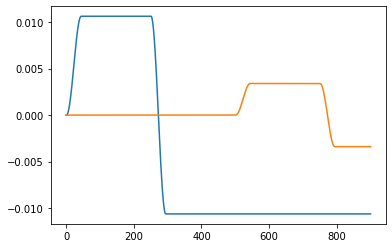

Please select steady state for mode 0:
450
Please select steady state for mode 1:
850


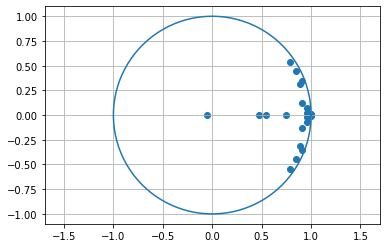

In [17]:
stabilisation = 2  # Brunton stabilisation, please look at the configuration template for more details
database.thresholding = 25
rom = aerodynamics.ROM([database], model, stabilisation)

import numpy as np
w, v = np.linalg.eig(rom.A)

import matplotlib.pyplot as plt
import math
plt.scatter(w.real,w.imag)

# The system stability is determined by the eigenvalues, they should be inside the unit circle
theta = np.linspace(0,2*math.pi,200)
x = np.cos(theta)
y = np.sin(theta)
plt.plot(x,y)
plt.axis('equal')
plt.grid()
plt.savefig('eigenvalues.eps', format='eps')

In [18]:
# The idea behind this stabilisation procedure is to split the steady contribution to the forces from the unsteady one
# Here, we reuse the same lines of code that are inside the ROM creation to better understand the steps...
# Firts, we define as a reference the initial condition (after the transient)
Xcenter = database.X[:, 0]
Xcenter = Xcenter.reshape((len(Xcenter), 1))

In [19]:
# We then define some variables required later
nModes = database.U.shape[0]
referenceSnapshots = np.empty((database.X.shape[0], nModes+1))
referenceSnapshots[:, 0] = database.X[:,0]
referenceSnapshotsSlope = np.empty((database.X.shape[0], nModes))
stateToSubract = np.zeros((database.X.shape[0], database.X.shape[1]))

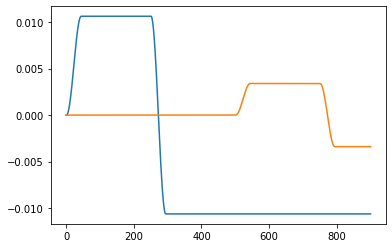

In [20]:
# We plot the inputs, and we request the user to identify the condition when the mode has stopped changing, but the others
# did not start yet. Please note that, by construction, this type of stabilisation only works if blended steps are used
# as training signals.
for i in range(nModes):
    plt.plot(np.array([x for x in range(database.U.shape[1])]), database.U[i, :])
plt.show()

In [21]:
# We can see that the first mode (plunge) stopped changing at time iteration 450, so we take that as a reference state
referenceSnapshots[:, 1] = database.X[:, 450]

In [22]:
# The slope of state change will be given by this new reference, minus the initial condition, divided by the input
# amplitude at the reference iteration (450)
referenceSnapshotsSlope[:, 0] = (referenceSnapshots[:, 1] - referenceSnapshots[:, 0])/database.U[0, 450]

In [23]:
# At each time step, we can then obtain the change in state due to the steady part as the slope times the input.
# We store this in a matrix with same dimensions of the state snapshot matrix
for j in range(database.X.shape[1]):
    stateToSubract[:, j] = stateToSubract[:, j] + referenceSnapshotsSlope[:, 0]*database.U[0, j]

Text(0, 0.5, 'Lift [N]')

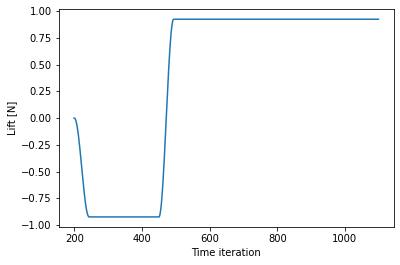

In [24]:
# To double check, we can plot the steady contribution to the lift due to plunge. In theory, it should be exactly zero. However,
# due to the mesh deformation, we have small changes.
nTimeIter = database.X.shape[1]
lift = []
for i in range(nTimeIter):
    lift = np.append(lift, model.getCl(stateToSubract[:,i]))

plt.plot(database.timeIter, lift)
# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Lift [N]")

Text(0, 0.5, 'Lift [N]')

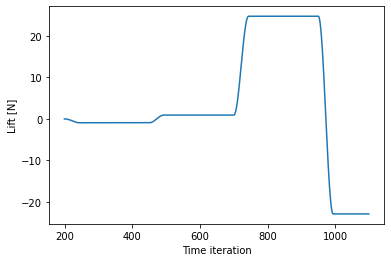

In [25]:
# We do just the same for the pitch and then we plot the change in lift due to both
referenceSnapshots[:, 2] = database.X[:, 850]
referenceSnapshotsSlope[:, 1] = (referenceSnapshots[:, 2] - referenceSnapshots[:, 1])/database.U[1, 850]
for j in range(database.X.shape[1]):
    stateToSubract[:, j] = stateToSubract[:, j] + referenceSnapshotsSlope[:, 1]*database.U[1, j]
lift = []
for i in range(nTimeIter):
    lift = np.append(lift, model.getCl(stateToSubract[:,i]))

plt.plot(database.timeIter, lift)
# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Lift [N]")

Text(0, 0.5, 'Lift [N]')

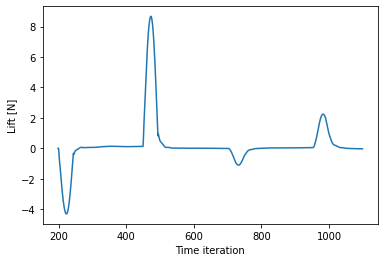

In [26]:
# If we then subtract, from the state, the initial condition and the steady part, we obtain the change in lift due to the
# unsteady part only. As expected, it is zero when no velocity or acceleration is present.
lift = []
state = database.X - rom.Xcenter - stateToSubract
for i in range(nTimeIter):
    lift = np.append(lift, model.getCl(state[:, i]))

plt.plot(database.timeIter, lift)
# just make the plot pretty
plt.xlabel("Time iteration")
plt.ylabel("Lift [N]")

In [27]:
# The DMDc is then trained with this modified state and thanks to this the stability of the obtained system
# is increased

Completed time integration


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


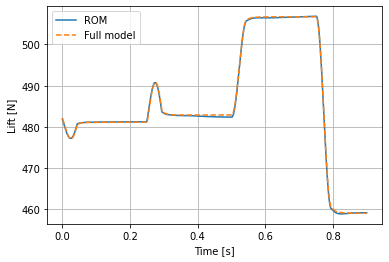

In [28]:
# Again, sanity check to confirm that we can reproduce the training signal

lift = np.empty((0))
aeroState = np.empty((database.X.shape[0], 0))

from sys import stdout
for i in range(len(database.timeIter)):
    stdout.write("\rTime iteration " + str(i+1) + " of " + str(len(database.timeIter)))
    stdout.flush()
    
    aeroState = np.append(aeroState, rom.predict(database.U[:,i], database.Udot[:,i], 
                                                 database.Uddot[:,i]).reshape(database.X.shape[0], 1) -
                                     rom.Xcenter, axis=1)
    
    lift = np.append(lift, rom.getLift(), axis=0)
    
    rom.update()
    
    
stdout.write("\rCompleted time integration\n")
stdout.flush()
      
lift_ref = []

for i in range(len(database.timeIter)):
    lift_ref = np.append(lift_ref, model.getCl(database.X[:,i]))

plt.plot(0.001*np.linspace(0, len(database.timeIter)-1, len(database.timeIter)), lift, '-')
plt.plot(0.001*np.linspace(0, len(database.timeIter)-1, len(database.timeIter)), lift_ref, '--')
# just make the plot pretty
plt.xlabel("Time [s]")
plt.ylabel("Lift [N]")
plt.legend(["ROM","Full model"])
plt.grid()
plt.savefig('tutorial3.eps', format='eps')

In [29]:
# The significantly increased accuracy can here be seen. Also, the model could be reduced in size to only 25 
# aerodynamic states

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


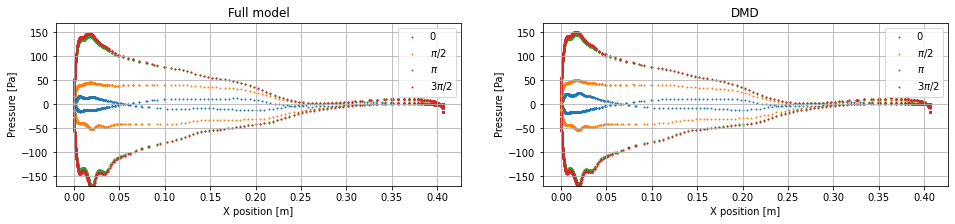

In [30]:
# We also plot the same quantities of the previous tutorial

# The data we want must be extracted for a y value of 0.1 m
# We first find the index of time step 700 and 730
index700 = database.timeIter == 700
index722 = database.timeIter == 722
index745 = database.timeIter == 745
index767 = database.timeIter == 767

# We now extract the vertices close to y = 0.1 m (1 cm close)
undeformedx = np.empty((0))
undeformedy = np.empty((0))
for i in range(len(model.undeformedShape)):
    undeformedx = np.append(undeformedx, model.undeformedShape[i].ux)
    undeformedy = np.append(undeformedy, model.undeformedShape[i].uy)
    
pressure_ref = database.X - rom.Xcenter
    
positionx = undeformedx[(undeformedy < 0.11) & (undeformedy > 0.09)]
pressure700_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index700]
pressure722_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index722]
pressure745_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index745]
pressure767_ref = pressure_ref[(undeformedy < 0.11) & (undeformedy > 0.09), index767]
pressure700 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index700]
pressure722 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index722]
pressure745 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index745]
pressure767 = aeroState[(undeformedy < 0.11) & (undeformedy > 0.09), index767]
   
plt.figure(figsize=(16,3))

# In blue we will have the distribution before pitching, in orange after

plt.subplot(1,2,1)
plt.scatter(positionx, pressure700_ref, marker='o', s=1)
plt.scatter(positionx, pressure722_ref, marker='o', s=1)
plt.scatter(positionx, pressure745_ref, marker='o', s=1)
plt.scatter(positionx, pressure767_ref, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("Full model")
plt.legend(["0","$\pi$/2","$\pi$","3$\pi$/2"])
plt.ylim(-170,170)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(positionx, pressure700, marker='o', s=1)
plt.scatter(positionx, pressure722, marker='o', s=1)
plt.scatter(positionx, pressure745, marker='o', s=1)
plt.scatter(positionx, pressure767, marker='o', s=1)
plt.xlabel("X position [m]")
plt.ylabel("Pressure [Pa]")
plt.title("DMD")
plt.legend(["0","$\pi$/2","$\pi$","3$\pi$/2"])
plt.ylim(-170,170)
plt.grid()

plt.savefig('pressure.eps', format='eps')